In [1]:
try: 
    af_indirs = snakemake.params.af_indirs
    indir = snakemake.params.indir
    outdir = snakemake.params.outdir
    donor = snakemake.wildcards.d
    weights = snakemake.params.weights
    anno_cells_meta_f = snakemake.input.anno_cells_meta_f
    objectives_l = snakemake.params.get("objectives_l", 
                                        ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                                         "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                                         "pct_thresh","other_pct_thresh", 
                                         "n_vars", "obj_nclones_more_than_one_unique"])
except:
    af_indirs = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"
    indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/"
    outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/optim_results/"
    donor = 0
    anno_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
    weights = [1,0,0,1,-1, 1, 1]
    objectives_l = ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                    "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                    "pct_thresh","other_pct_thresh", "n_vars", "obj_nclones_more_than_one_unique"] #"nvars"

    
param_names = ["pct_thresh","af_thresh", "other_pct_thresh"]


In [2]:
import src.clone_variants_optim  as optim
from mplh import cluster_help as ch

from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage

import mplh.cluster_help as ch
import mplh.fig_utils as fu

fig_utils from mplh


In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists, dirname
from glob import glob
import pickle
from icecream import ic
ic.disable()
np.set_printoptions(formatter={'float': lambda x: format(x, '.3f')})
# matplotlib.rcParams['ps.useafm'] = False
# matplotlib.rcParams['pdf.use14corefonts'] = True
# matplotlib.rcParams['text.usetex'] = False

# Load results and get top 10% of them

In [4]:
obj_norm_results = pd.read_csv(join(indir, "objectives_norm.csv"), index_col=0)
obj_results = pd.read_csv(join(indir, "objectives.csv"), index_col=0)
obj_results = pd.read_csv(join(indir, "objectives_rank.csv"), index_col=0)
param_results = pd.read_csv(join(indir, "params.csv"), index_col=0)

# top 10%
top10perc_n = int(obj_norm_results.shape[0]*0.1)
obj_norm_top10perc = obj_norm_results.iloc[:top10perc_n]
top10perc_n

param_results = param_results.loc[obj_norm_top10perc.index]
# obj_norm_top10perc_params = pd.merge(left=obj_norm_top10perc, right=param_results, left_index=True, right_index=True, how="left", 
#                                      suffixes=["_obj", ""])


## Cluster top results by objectives and get a dynamic tree cut of the dendrogram

..cutHeight not given, setting it to 0.0018354335356670502  ===>  99% of the (truncated) height range in dendro.
..done.


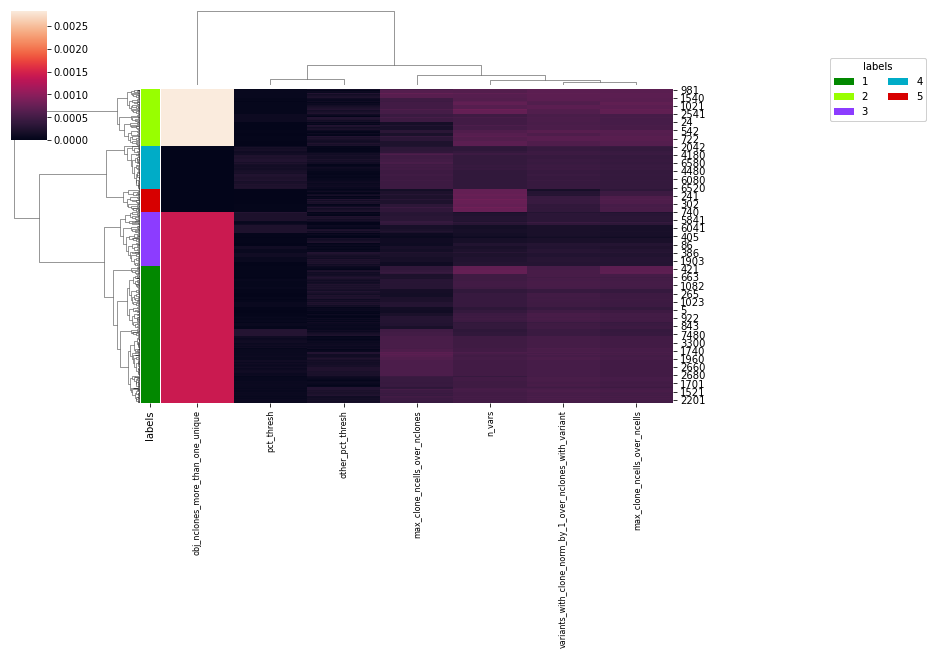

In [5]:

# g = sns.clustermap(obj_norm_top10perc)
# g.fig.suptitle("Top 10% objective scores")
# plt.savefig(join(outdir, "top10_objectives.png"))


#d = np.transpose(np.arange(1,10001).reshape(100,100))

distances = pdist(obj_norm_top10perc.drop("multi", axis=1).values, "euclidean")
link = linkage(distances, "average")
clusters = cutreeHybrid(link, distances)
# ..cutHeight not given, setting it to 495.1  ===>  99% of the (truncated) height range in dendro.
# ..done.
clusters["labels"]
clusters["ID"] = obj_norm_top10perc.index
clusters = pd.DataFrame({"ID":clusters["ID"], "labels": clusters["labels"]}, index=obj_norm_top10perc.index)#[["ID", "labels"]]

param_results = pd.merge(clusters, param_results, left_index=True, right_index=True, how="inner")
ch.plot_cluster(obj_norm_top10perc.drop("multi", axis=1), row_meta=clusters[["labels"]])
plt.savefig(join(outdir, "top10_objective_clusters.pdf"), dpi=300)

## Get average parameters for each params-cluster 

In [6]:
top_params_mean_df = param_results.groupby("labels").mean().drop("ID", axis=1)
top_params_mean_df

,pct_thresh,other_pct_thresh,af_thresh
labels,,,
1,0.263522,0.511918,0.080472
2,0.149618,0.511870,0.084771
3,0.388492,0.460556,0.148254
4,0.686275,0.306961,0.014314
5,0.066981,0.456887,0.053113


##  Get the clone-variant table for each params-cluster


### First load the AF, DP, and cells_meta data

In [7]:
af_indir = join(af_indirs, "sc_af", f"donor{donor}")

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

cells_meta = pd.read_csv(join(indir, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==donor]
curr_labels

conditions = curr_labels["condition"].unique()
conditions

def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Get donor inds
donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]

AF_df.shape

(68, 9023)

## Then, create the clone-var table for the clustered params and get their objective scores based on the weights
Store the results in results_norm_params, which has params, objectives, and solution cluster  
Also store the tables in all_df, which is the long-form of clone, variant, ncells, and params

In [8]:
all_df = []
all_objs = {}
for ind, val in top_params_mean_df.iterrows():
    print(ind)
    obj_out, data = optim.evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True)
    all_df.append(data["all_unique_df"])
    all_objs[ind] = obj_out 
all_df = pd.concat(all_df)

results_df = pd.DataFrame(all_objs).transpose()
results_norm = optim.set_multi(results_df, weights)
rank_df = optim.set_multi_rank(results_norm, weights)

all_df["params"] = all_df.apply(optim.params_to_str, axis=1,
                                args=(param_names,))

## merge param and results
results_norm_params = pd.merge(left=top_params_mean_df, right=results_norm, right_index=True, left_index=True, suffixes=["", "_obj"])

results_norm_params["params"] = results_norm_params.apply(optim.params_to_str, axis=1,
                                args=(param_names,))
results_norm_params.index.name = "solution_cluster"
results_norm_params = results_norm_params.reset_index().set_index("params")


1
2
3
4
5
(5, 7)
objs_total variants_with_clone_norm_by_1_over_nclones_with_variant      43.750000
max_clone_ncells_over_nclones                              3553.250000
max_clone_ncells_over_ncells                                 45.748850
pct_thresh                                                    1.554888
other_pct_thresh                                              2.248192
dtype: float64


### sort by multi


In [9]:
results_norm_params = results_norm_params.sort_values(["multi"])[::-1]

results_norm_params

,solution_cluster,pct_thresh,other_pct_thresh,af_thresh,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,n_vars,obj_nclones_more_than_one_unique,multi
params,,,,,,,,,,,,
pct_thresh=0.067\naf_thresh=0.053\nother_pct_thresh=0.457\n,5,0.066981,0.456887,0.053113,0.451429,0.256033,0.451610,0.043078,0.203224,0.44,0.500000,1.231282
pct_thresh=0.686\naf_thresh=0.014\nother_pct_thresh=0.307\n,4,0.686275,0.306961,0.014314,0.160000,0.253711,0.158219,0.441366,0.136537,0.16,0.166667,0.791496
pct_thresh=0.264\naf_thresh=0.080\nother_pct_thresh=0.512\n,1,0.263522,0.511918,0.080472,0.160000,0.196862,0.159000,0.169480,0.227702,0.16,0.166667,0.428444
pct_thresh=0.150\naf_thresh=0.085\nother_pct_thresh=0.512\n,2,0.149618,0.511870,0.084771,0.160000,0.194048,0.159000,0.096224,0.227681,0.16,0.166667,0.355210
pct_thresh=0.388\naf_thresh=0.148\nother_pct_thresh=0.461\n,3,0.388492,0.460556,0.148254,0.068571,0.099346,0.072170,0.249852,0.204856,0.08,0.000000,0.193568


## Add multi_obj and solution_cluster label to the long clone-table and to the results

In [10]:
all_df["multi_obj"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "multi"], axis=1)
all_df["solution_cluster"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "solution_cluster"], axis=1)
all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)
clones_order, variants_order, heatmap_input = optim.prep_long_heatmap(all_df)
all_df["solution_params_obj"] = all_df.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
all_df

results_norm_params = results_norm_params.reset_index()
results_norm_params["multi_obj"] = results_norm_params["multi"]
results_norm_params["params_multi"] = results_norm_params.apply(optim.params_and_multi_str, axis=1)

results_norm_params["solution_params_obj"] = results_norm_params.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
results_norm_params

,params,solution_cluster,pct_thresh,other_pct_thresh,af_thresh,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,n_vars,obj_nclones_more_than_one_unique,multi,multi_obj,params_multi,solution_params_obj
0,pct_thresh=0.067\naf_thresh=0.053\nother_pct_t...,5,0.066981,0.456887,0.053113,0.451429,0.256033,0.451610,0.043078,0.203224,0.44,0.500000,1.231282,1.231282,params:\npct_thresh=0.067\naf_thresh=0.053\not...,solution:5\n params:\npct_thresh=0.067\naf_thr...
1,pct_thresh=0.686\naf_thresh=0.014\nother_pct_t...,4,0.686275,0.306961,0.014314,0.160000,0.253711,0.158219,0.441366,0.136537,0.16,0.166667,0.791496,0.791496,params:\npct_thresh=0.686\naf_thresh=0.014\not...,solution:4\n params:\npct_thresh=0.686\naf_thr...
2,pct_thresh=0.264\naf_thresh=0.080\nother_pct_t...,1,0.263522,0.511918,0.080472,0.160000,0.196862,0.159000,0.169480,0.227702,0.16,0.166667,0.428444,0.428444,params:\npct_thresh=0.264\naf_thresh=0.080\not...,solution:1\n params:\npct_thresh=0.264\naf_thr...
3,pct_thresh=0.150\naf_thresh=0.085\nother_pct_t...,2,0.149618,0.511870,0.084771,0.160000,0.194048,0.159000,0.096224,0.227681,0.16,0.166667,0.355210,0.355210,params:\npct_thresh=0.150\naf_thresh=0.085\not...,solution:2\n params:\npct_thresh=0.150\naf_thr...
4,pct_thresh=0.388\naf_thresh=0.148\nother_pct_t...,3,0.388492,0.460556,0.148254,0.068571,0.099346,0.072170,0.249852,0.204856,0.08,0.000000,0.193568,0.193568,params:\npct_thresh=0.388\naf_thresh=0.148\not...,solution:3\n params:\npct_thresh=0.388\naf_thr...


## Plot objective scores across different params-cluster labels

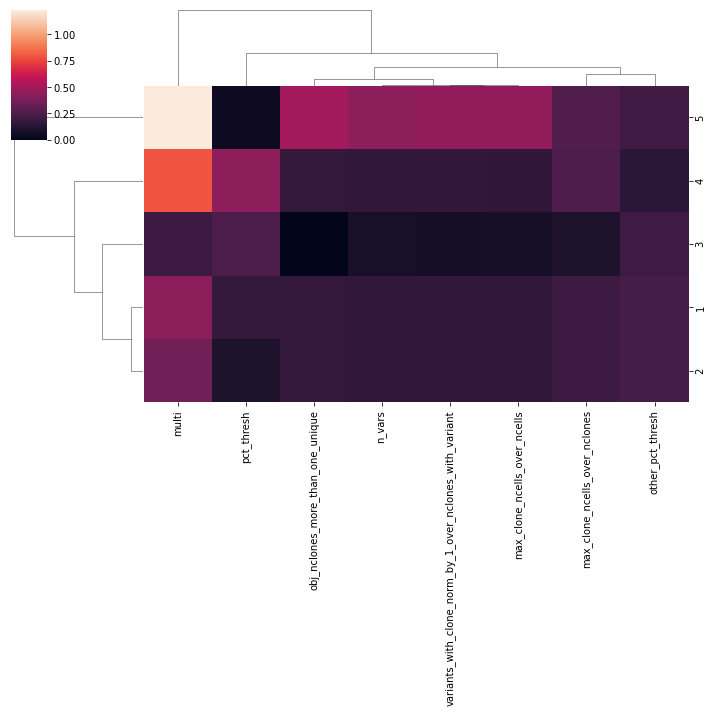

In [11]:
sns.clustermap(results_norm)
plt.savefig(join(outdir, "top_param_group_results.png"))
plt.savefig(join(outdir, "top_param_group_results.pdf"))

## Plot cluster clone-var table

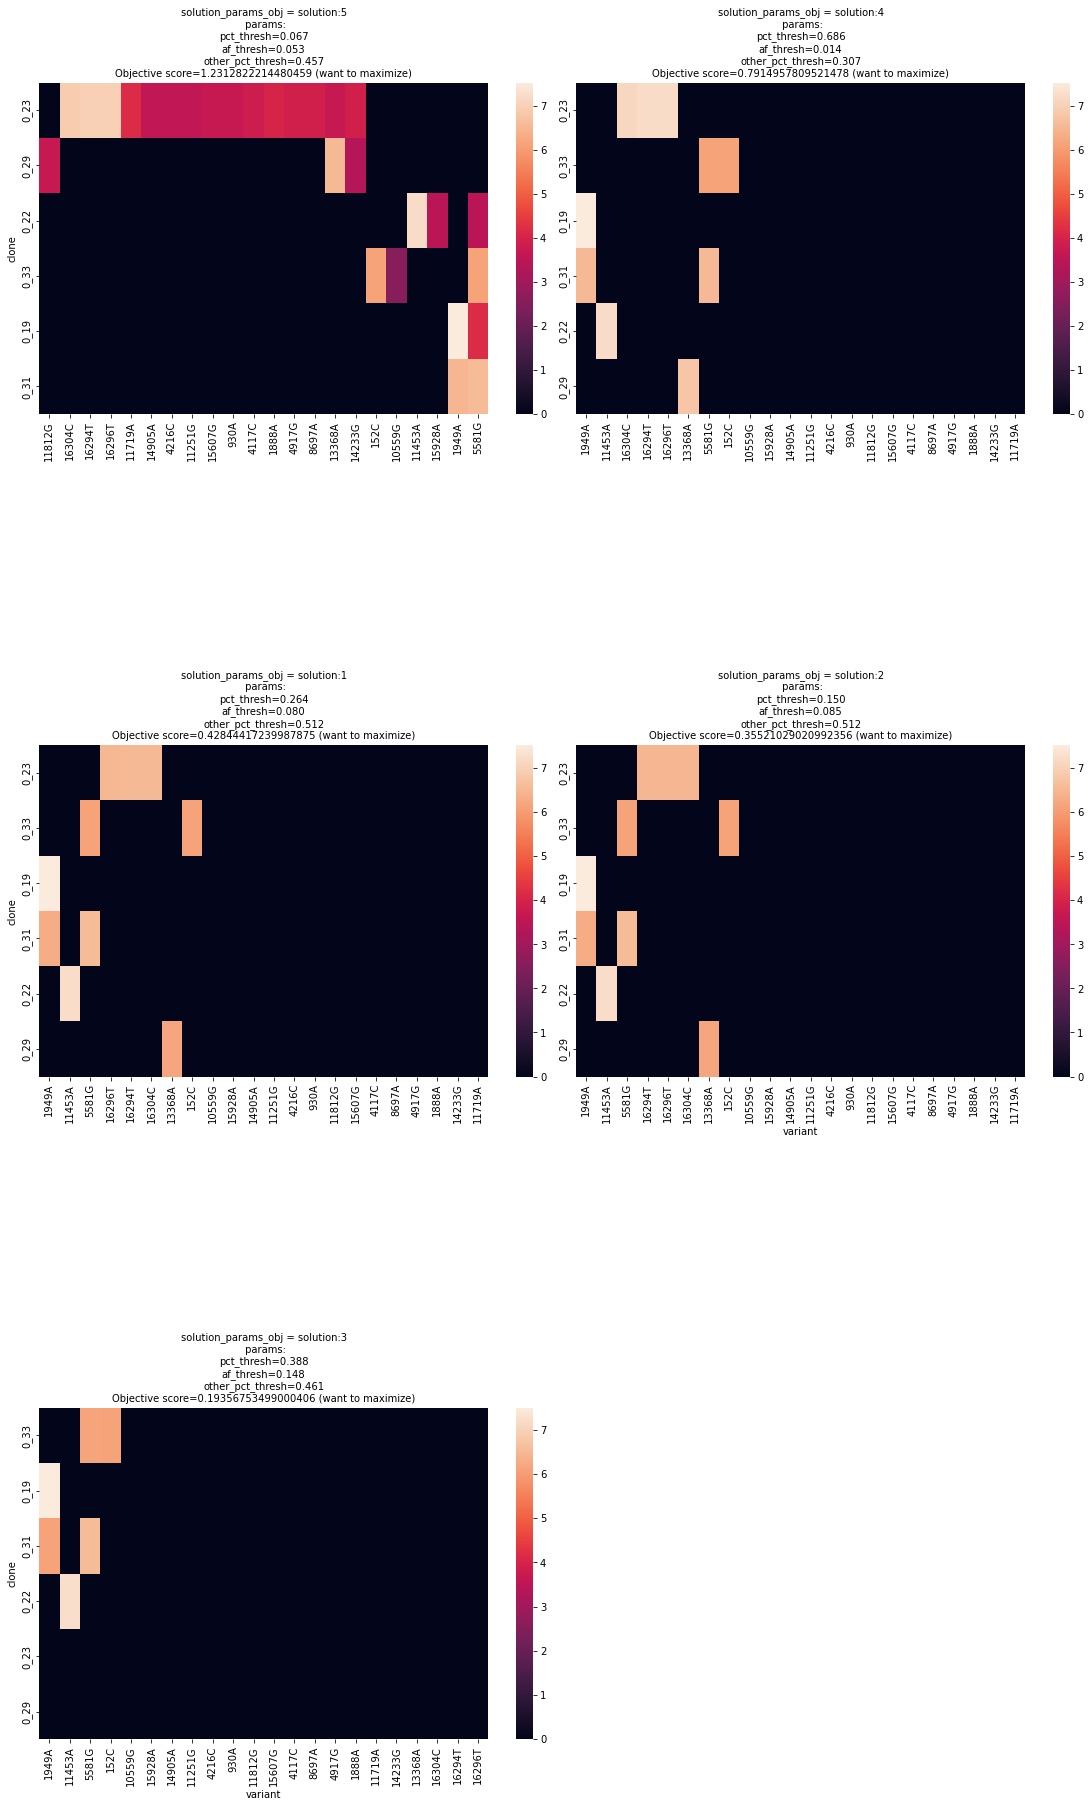

In [12]:
fg = sns.FacetGrid(data=all_df.reset_index(), height=4, aspect=2, sharey=False, sharex=False, 
                   col="solution_params_obj", col_wrap=2, 
                   col_order=results_norm_params["solution_params_obj"].values, margin_titles=False)

fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells', 
                 clones_order=clones_order, 
                 variants_order=variants_order)#, cbar=False)
#fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
#fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=2, hspace = 1)

plt.savefig(join(outdir, "top_param_groups_clone_vars.pdf"), dpi=300)

In [13]:
for ind, val in all_df.groupby("solution_params_obj"):
    print(ind)
    curr_dir = join(outdir, "best_params_clusters")
    if not exists(curr_dir):
        os.mkdir(curr_dir)
    curr_name = val["params"][0].replace("=", "__").replace("\n", "___").strip("_")
    curr_table = val.reset_index().pivot(index="clone",columns="variant",values="n_cells").fillna(0).astype(int)
    curr_table.to_csv(join(curr_dir, f"clone_variants.{curr_name}.csv"))

solution:1
 params:
pct_thresh=0.264
af_thresh=0.080
other_pct_thresh=0.512
Objective score=0.42844417239987875 (want to maximize)
solution:2
 params:
pct_thresh=0.150
af_thresh=0.085
other_pct_thresh=0.512
Objective score=0.35521029020992356 (want to maximize)
solution:3
 params:
pct_thresh=0.388
af_thresh=0.148
other_pct_thresh=0.461
Objective score=0.19356753499000406 (want to maximize)
solution:4
 params:
pct_thresh=0.686
af_thresh=0.014
other_pct_thresh=0.307
Objective score=0.7914957809521478 (want to maximize)
solution:5
 params:
pct_thresh=0.067
af_thresh=0.053
other_pct_thresh=0.457
Objective score=1.2312822214480459 (want to maximize)


## Get the top cluster score and save 

In [17]:
best_params = (results_norm_params.sort_values("multi_obj")[::-1]).iloc[0]
best_params

best_params = pd.DataFrame(best_params).transpose()
best_params.index = ["objective_scores"]
best_params.loc["weight"] = None

for obj, w in zip(objectives_l, weights):
    best_params.loc["weight", f"{obj}_obj"] = w

out_df = all_df[all_df['params'] == best_params.loc["objective_scores", "params"]]

clone_var_table = (out_df.pivot(index= 'variant',columns='clone', values='log2_n_cells').fillna(0))
clones_keep = clone_var_table.loc[:, ~((clone_var_table==0).all(axis=0))].columns
vars_keep = clone_var_table.loc[~((clone_var_table==0).all(axis=1))].index


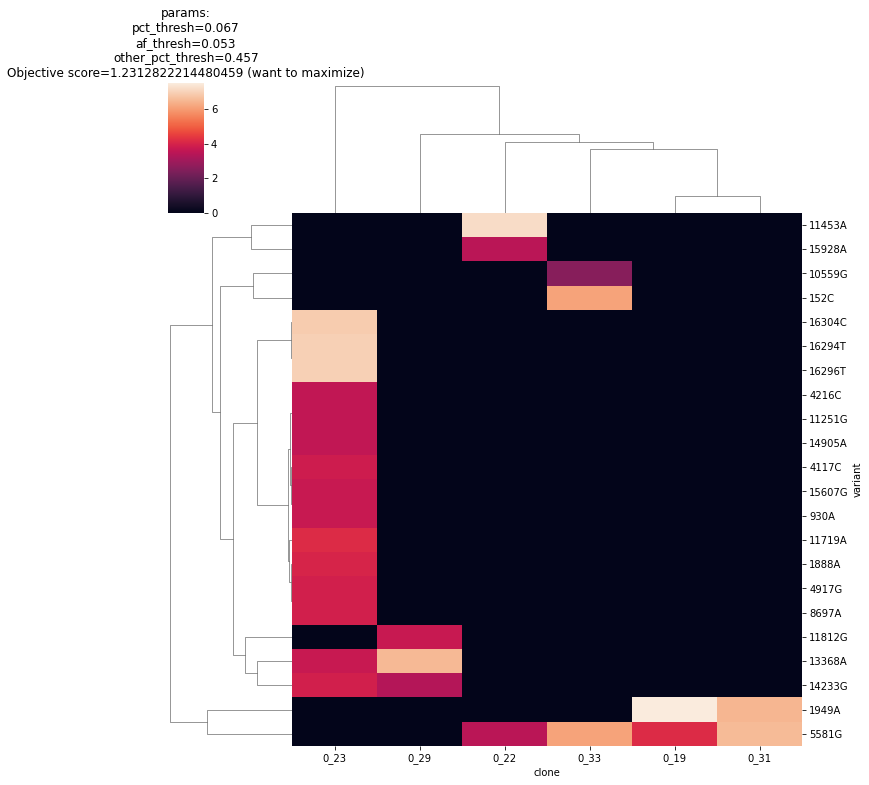

In [18]:
sns.clustermap(clone_var_table)
plt.title(best_params.loc["objective_scores", "params_multi"])
plt.savefig(join(outdir, "best_params.pdf"))

# sns.clustermap(clone_var_table.loc[vars_keep,clones_keep])
# plt.title(best_params.loc["objective_scores", "params_multi"])
# plt.savefig(join(outdir, "best_params_filt.pdf"))



In [19]:


# ## Save clone-variant table and the parameters
clone_var_table.to_csv(join(outdir, "best_params_clone_vars.csv"))
clone_var_table.loc[vars_keep,clones_keep].to_csv(join(outdir, "best_params_filt_clone_vars.csv"))
best_params.to_csv(join(outdir, "best_params.csv"))

anno_cells = pd.read_csv(anno_cells_meta_f, sep="\t", index_col=0)

filt_curr_labels = curr_labels[curr_labels["name"].isin(clones_keep)]

# overlap cells of anno and curr labels
cells_to_keep = set(anno_cells["ID"].values).intersection(set(filt_curr_labels.index))
out_cells_meta = anno_cells.loc[anno_cells["ID"].isin(cells_to_keep)]
#out_cells_meta =  out_cells_meta.reset_index().set_index("ID")

# out_AF_df = AF_df.loc[vars_keep, out_cells_meta.index]
# out_DP_df = DP_df.loc[vars_keep, out_cells_meta.index]
print(out_cells_meta.head())
out_AF_df = AF_df.loc[vars_keep, out_cells_meta["ID"]].transpose()
out_DP_df = DP_df.loc[vars_keep, out_cells_meta["ID"]].transpose()


print(out_cells_meta.shape)
print(out_AF_df.shape)
print(out_DP_df.shape)

assert((out_AF_df.index==out_DP_df.index).all())
assert((out_AF_df.columns==out_DP_df.columns).all())
assert((out_AF_df.index==out_cells_meta["ID"]).all())


# ## save cells-meta, af and dp
out_cells_meta["ID"]

out_cells_meta.to_csv(join(outdir, "cells_meta.tsv"),sep="\t")
out_AF_df.to_csv(join(outdir, "af.tsv"), sep="\t")
out_DP_df.to_csv(join(outdir, "dp.tsv"), sep="\t")

outdir



                           orig.ident  nCount_ATAC  nFeature_ATAC  total  \
Control_AAACGAATCAGGCGCT-1    Control         7347           7347  33434   
Control_AAAGGATAGATAGGTT-1    Control         3077           3077  14220   
Control_AAAGGGCTCAGTGGTT-1    Control         1883           1883  10664   
Control_AACAGTCTCCCTACCA-1    Control         2816           2816   9966   
Control_AACATCGTCTGAAAGA-1    Control         1460           1460   5818   

                            duplicate  chimeric  unmapped  lowmapq  \
Control_AAACGAATCAGGCGCT-1       6309       129       123     1245   
Control_AAAGGATAGATAGGTT-1       1924        52        44      889   
Control_AAAGGGCTCAGTGGTT-1       1484        43        26      352   
Control_AACAGTCTCCCTACCA-1       1527        28        22      397   
Control_AACATCGTCTGAAAGA-1        806        20        20      219   

                            mitochondrial  passed_filters  ...  \
Control_AAACGAATCAGGCGCT-1           8223           1740

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/optim_results/'